In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
import pathlib

In [5]:
import numpy as np
import pandas as pd
import xarray as xr

In [6]:
import sys

In [7]:
sys.path.append('/home/nicolasf/research/Smart_Ideas/code/ml4seas/')

In [8]:
from GCM import regrid
from GCM import (fix_grid, preprocess_ECMWF_nc)
from utils import (list_files, save_by_month)

xesmf is not installed, using method `interp_like` for interpolation


In [9]:
provider = 'CDS'

In [10]:
GCM = 'ECMWF'

In [11]:
varname = 'Z500'

In [12]:
save_clim = True

### path where the files have been downloaded 

In [13]:
dpath = f'/media/nicolasf/END19101/data/GCMs/downloads/{GCM}/{varname}'

In [14]:
dpath = pathlib.Path(dpath)

### list the files 

In [15]:
lfiles = list_files(dpath, pattern=f"*{GCM}*", extension=".nc", verbose=1)

loaded files, list length 468
the first file is /media/nicolasf/END19101/data/GCMs/downloads/ECMWF/Z500/CDS_ECMWF_Z500_1981_01.nc
the last file is /media/nicolasf/END19101/data/GCMs/downloads/ECMWF/Z500/CDS_ECMWF_Z500_2019_12.nc


In [16]:
dset_all = xr.open_mfdataset(lfiles, concat_dim='init_time', preprocess=preprocess_ECMWF_nc, parallel=True)

In [19]:
if varname == 'PRECIP': 
    dset_all = convert_rainfall(dset_all, time_var='init_time')

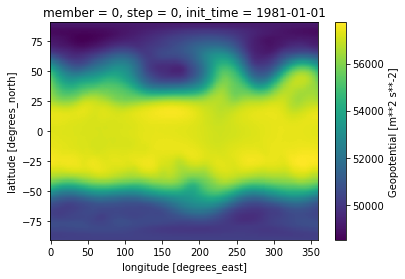

In [20]:
dset_all['z'].isel(init_time=0, step=0, member=0).plot()

### calculates the climatology 

In [21]:
clim_years = ['1981', '2010']
# clim_years = ['1993','2016']

In [22]:
clim = dset_all.sel(init_time=slice(*clim_years)).mean('member')

In [23]:
clim = clim.groupby(clim.init_time.dt.month).mean()

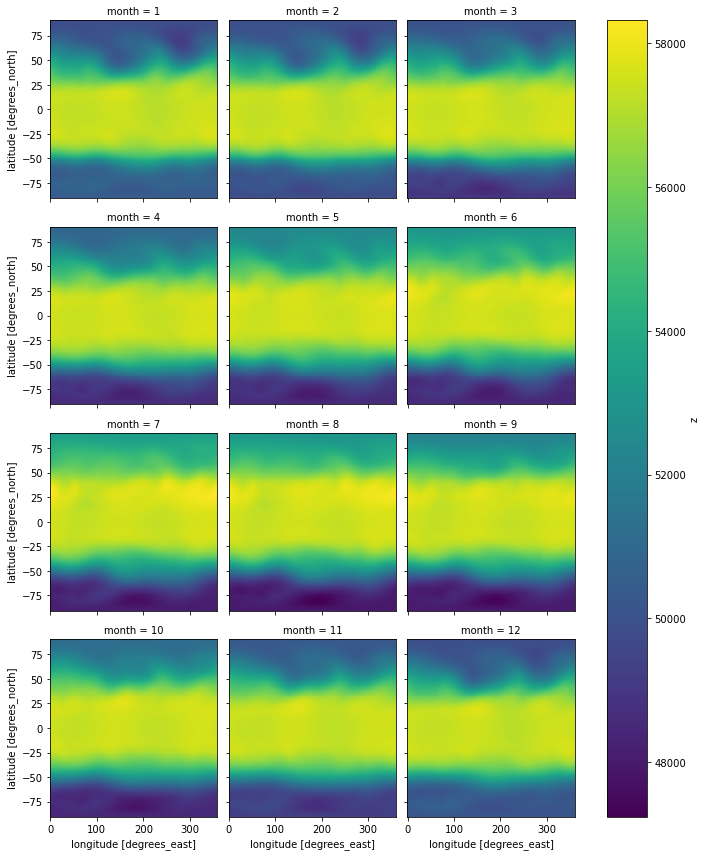

In [24]:
fg = clim.isel(step=0)['z'].plot(x='lon',y='lat', col='month', col_wrap=3) 

In [25]:
if varname == 'PRECIP': 
    clim = clim.drop('ndays')

In [26]:
opath = dpath.parents[2].joinpath(f'processed/{provider}/{GCM}/{varname}')

print(str(opath))

if not opath.exists():
    opath.mkdir(parents=True)

clim_path = opath.joinpath('CLIMATOLOGY')

if not clim_path.exists():
    clim_path.mkdir(parents=True)

/media/nicolasf/END19101/data/GCMs/processed/CDS/ECMWF/Z500


In [27]:
clim_path

PosixPath('/media/nicolasf/END19101/data/GCMs/processed/CDS/ECMWF/Z500/CLIMATOLOGY')

### saves the climatology to disk 

In [28]:
if save_clim: 
    for m in clim.month.data: 
        c = clim.sel(month=m) 
        fname_out = f"CDS_ECMWF_{varname}_monthly_{'_'.join(clim_years)}_clim_{str(m).zfill(2)}.nc"
        c.to_netcdf(clim_path.joinpath(fname_out))
        c.close()

### calculates the monthly anomalies 

In [29]:
anoms = (dset_all.groupby(dset_all.init_time.dt.month)) - clim

In [30]:
anoms

,Array,Chunk
Bytes,18.30 GB,39.10 MB
Shape,"(468, 6, 25, 181, 360)","(1, 6, 25, 181, 360)"
Count,6708 Tasks,468 Chunks
Type,float32,numpy.ndarray


### plots some anomalies to check if they make sense 

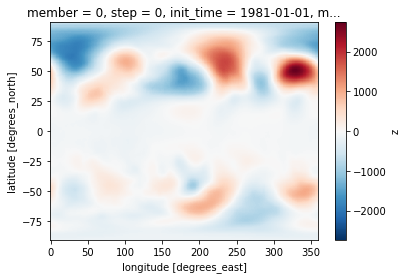

In [31]:
anoms['z'][0,0,0,:,:].plot()

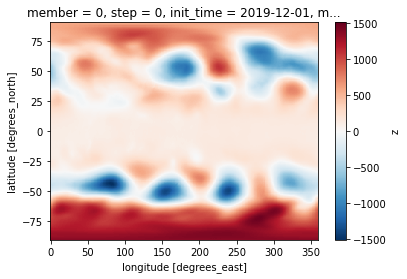

In [32]:
anoms['z'][-1,0,0,:,:].plot()

### plots the ENSO 1997 - 1998

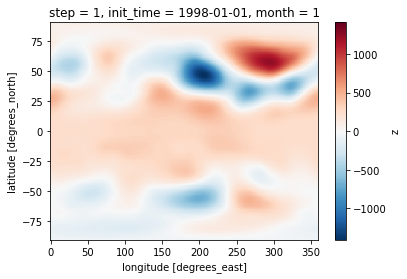

In [33]:
anoms.sel(init_time='1998-01-01')['z'].mean('member').isel(step=1).plot()

### opens the target grid for interpolation 

In [34]:
out_grid = xr.open_dataset('/media/nicolasf/END19101/data/GCMs/target_grid/target_grid_2.5_2.5.nc')

### saves the monthly anomalies, non interpolated 

In [35]:
save_by_month(anoms, opath=opath, provider=provider, GCM=GCM, varname=varname, append=f"monthly_anomalies_{'_'.join(clim_years)}_clim", verbose=False)

### calculates the seasonal averages (of the anomalies )

In [36]:
anoms_seas = anoms.rolling(step=3, min_periods=3).mean()

In [37]:
anoms_seas = anoms_seas.dropna(dim='step')

### saves the seasonal anomalies, non interpolated 

In [38]:
save_by_month(anoms_seas, opath=opath, provider=provider, GCM=GCM, varname=varname, append=f"seasonal_anomalies_{'_'.join(clim_years)}_clim", verbose=True)

successfully saved CDS_ECMWF_Z500_1981-01_seasonal_anomalies_1981_2010_clim.nc
successfully saved CDS_ECMWF_Z500_1981-02_seasonal_anomalies_1981_2010_clim.nc
successfully saved CDS_ECMWF_Z500_1981-03_seasonal_anomalies_1981_2010_clim.nc
successfully saved CDS_ECMWF_Z500_1981-04_seasonal_anomalies_1981_2010_clim.nc
successfully saved CDS_ECMWF_Z500_1981-05_seasonal_anomalies_1981_2010_clim.nc
successfully saved CDS_ECMWF_Z500_1981-06_seasonal_anomalies_1981_2010_clim.nc
successfully saved CDS_ECMWF_Z500_1981-07_seasonal_anomalies_1981_2010_clim.nc
successfully saved CDS_ECMWF_Z500_1981-08_seasonal_anomalies_1981_2010_clim.nc
successfully saved CDS_ECMWF_Z500_1981-09_seasonal_anomalies_1981_2010_clim.nc
successfully saved CDS_ECMWF_Z500_1981-10_seasonal_anomalies_1981_2010_clim.nc
successfully saved CDS_ECMWF_Z500_1981-11_seasonal_anomalies_1981_2010_clim.nc
successfully saved CDS_ECMWF_Z500_1981-12_seasonal_anomalies_1981_2010_clim.nc
successfully saved CDS_ECMWF_Z500_1982-01_seasonal_a

### Now interpolates onto the 2.5 x 2.5 grid and saves to file

In [39]:
anoms_interp = anoms.interp_like(out_grid)

In [40]:
save_by_month(anoms_interp, opath=opath, provider=provider, GCM=GCM, varname=varname, append=f"monthly_anomalies_interp_{'_'.join(clim_years)}_clim", verbose=False)

In [41]:
anoms_seas_interp = anoms_seas.interp_like(out_grid)

In [42]:
save_by_month(anoms_seas_interp, opath=opath, provider=provider, GCM=GCM, varname=varname, append=f"seasonal_anomalies_interp_{'_'.join(clim_years)}_clim", verbose=False)